In [ ]:

import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import cv2


In [ ]:
import pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

def rgb_to_gray(image):
    return rgb2gray(image)

np.random.seed(14)
tf.random.set_seed(14)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
datagen.fit(np.zeros((1, 128, 128, 3)))

train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=2000,
    class_mode='binary',
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=208,
    class_mode='binary',
)

Found 9378 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


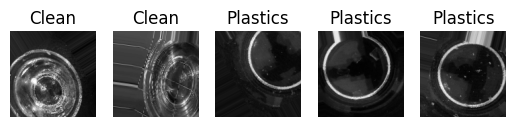

In [ ]:

batch = next(train_generator)

images, labels = batch

# Updating labels for better readability
updated_labels = ["Clean" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [ ]:
# Double checking the shape of the output from the resizing
# Even though images are Greyscale, we want to make sure that the color channels are 3, so they are compatable with MobileNetV2.
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [ ]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Training the Model
epochs = 30

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 522s 68s/step - accuracy: 0.5170 - loss: 1.0144 - val_accuracy: 0.5048 - val_loss: 0.7436
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7034 - loss: 0.5708 - val_accuracy: 0.4760 - val_loss: 0.7384
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8137 - loss: 0.4430 - val_accuracy: 0.5192 - val_loss: 0.9194
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8743 - loss: 0.3572 - val_accuracy: 0.4904 - val_loss: 0.9349
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8793 - loss: 0.3016 - val_accuracy: 0.5048 - val_loss: 1.1341
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8991 - loss: 0.2766 - val_accuracy: 0.5048 - val_loss: 1.2886
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9039 - loss: 0.2682 - val_accuracy: 0.4808 - val_loss: 1.1319
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9001 - loss: 0.2538 - val_accuracy: 0.4952 - val_loss: 1.0252
Epoch 9/50
3/3 ━

## Testing The Model Performence on Test data

In [ ]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(testing_generator)

print(f'Testing loss: {test_loss}')
print(f'Testing accuracy: {test_accuracy}')


In [ ]:

training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'


# More efficient model

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreezing the last few layers to allow fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze the first n layers
    layer.trainable = False


model2 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


batch_size = 32

train_generator_with_More = train_datagen.flow_from_directory(
    training_path,  # Replace with your data path
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
validation_generator_with_More = train_datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Train the model
history = model2.fit(
    train_generator_with_More,
    validation_data=validation_generator_with_More,  # Changed keyword argument
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Found 4506 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7764 - loss: 6.1852 - val_accuracy: 0.5500 - val_loss: 6.2666 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.9231 - loss: 4.9410 - val_accuracy: 0.5500 - val_loss: 5.0452 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.9462 - loss: 3.9110 - val_accuracy: 0.5500 - val_loss: 3.9945 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 306ms/step - accuracy: 0.9574 - loss: 3.0429 - val_accuracy: 0.7000 - val_loss: 3.0410 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.9625 - loss: 2.3321 - val_accuracy: 0.6750 - val_loss: 2.7320 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 316ms/step - accuracy: 0.9706 - loss: 1.7719 - val_accuracy: 0.7250 - val_loss: 2.0463 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - ac

In [ ]:

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model2.evaluate(train_generator_with_More)
valid_loss, valid_accuracy = model2.evaluate(validation_generator_with_More)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 333ms/step - accuracy: 0.9915 - loss: 0.0355
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9563 - loss: 0.1132
Training Accuracy: 0.9940080046653748
Training Loss: 0.031810462474823
----------------------------------------
Validation Accuracy: 0.949999988079071
Validation Loss: 0.13203787803649902


In [ ]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model2.evaluate(testing_generator)

print(f'Testing accuracy: {test_accuracy}')
print(f'Testing loss: {test_loss}')



Found 200 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4450 - loss: 2.6761
Testing accuracy: 0.4449999928474426
Testing loss: 2.676110029220581


# My model without using any Pretrained model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [ ]:

model = Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Increased dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [ ]:

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Low learning rate for smoother optimization
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]  # AUC for a detailed metric
)


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


In [ ]:

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)



training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'

# Data generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Training subset from training data
)
validation_generator = train_datagen.flow_from_directory(
    training_path,  # Use same directory but with validation split
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Validation subset
)

In [ ]:

# Compute class weights for imbalanced datasets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Adjust depending on resources
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    validation_path,  # Testing path for final evaluation
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Found 4506 images belonging to 2 classes.
Found 1126 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 427ms/step - AUC: 0.9460 - accuracy: 0.8935 - loss: 0.3758 - val_AUC: 1.0000 - val_accuracy: 0.9742 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 375ms/step - AUC: 0.9875 - accuracy: 0.9489 - loss: 0.1319 - val_AUC: 1.0000 - val_accuracy: 0.9849 - val_loss: 0.0696 - learning_rate: 1.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - AUC: 0.9919 - accuracy: 0.9524 - loss: 0.1094 - val_AUC: 1.0000 - val_accuracy: 0.9893 - val_loss: 0.0348 - learning_rate: 1.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - AUC: 0.9933 - accuracy: 0.9625 - loss: 0.0961 - val_AUC: 1.0000 - val_accuracy: 0.9867 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 371ms/step - AUC: 0.9918 - accuracy: 0.9566 - loss: 0.1106 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 365ms/step -

In [ ]:
# Print the final training and validation accuracy
training_accuracy = history.history['accuracy'][-1]  # Last training accuracy value
validation_accuracy = history.history['val_accuracy'][-1]  # Last validation accuracy value

print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Training Accuracy: 0.9916
Validation Accuracy: 1.0000


# Final Model


In [ ]:


model4 = Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Additional convolutional block (Increased complexity)
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),


    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with an optimized learning rate
model4.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'



batch_size = 32
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights in case of class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 4506 images belonging to 2 classes.
Found 1126 images belonging to 2 classes.


In [ ]:

# Train the model
history = model4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Adjust the number of epochs if needed
    class_weight=class_weights,  # Adjust for class imbalance
    callbacks=[early_stopping, reduce_lr]
)




Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 1654s 11s/step - accuracy: 0.8592 - loss: 0.3899 - val_accuracy: 0.9316 - val_loss: 0.2125 - learning_rate: 5.0000e-05
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9137 - loss: 0.2193 - val_accuracy: 0.9893 - val_loss: 0.0483 - learning_rate: 5.0000e-05
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9419 - loss: 0.1459 - val_accuracy: 0.9760 - val_loss: 0.0788 - learning_rate: 5.0000e-05
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9552 - loss: 0.1277 - val_accuracy: 0.9956 - val_loss: 0.0206 - learning_rate: 5.0000e-05
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9493 - loss: 0.1271 - val_accuracy: 0.9956 - val_loss: 0.0178 - learning_rate: 5.0000e-05
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.9484 - loss: 0.1324 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 5.0000e-05
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.

In [ ]:
# Evaluate the model using the test dataset
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    validation_path,  # Use test data for evaluation
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

Found 208 images belonging to 2 classes.


In [ ]:

test_loss, test_accuracy = model4.evaluate(test_generator)
print('\n')
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - accuracy: 0.9065 - loss: 0.4419


Test Accuracy: 0.8942, Test Loss: 0.4839


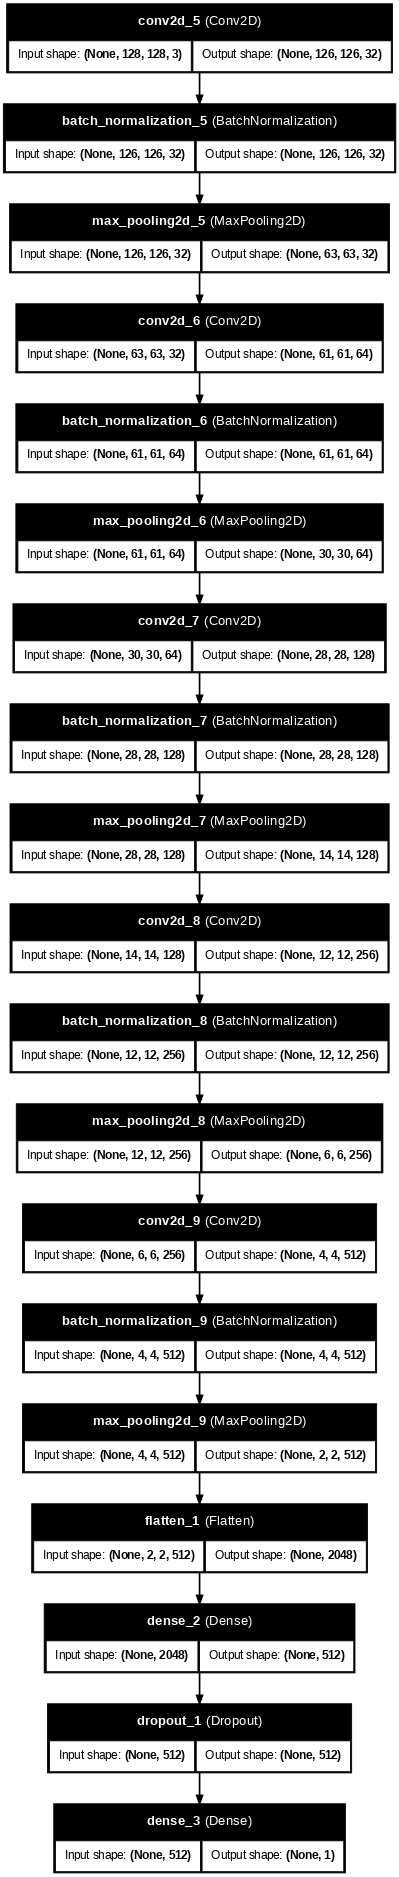

In [ ]:
from keras.utils import plot_model
plot_model(model4, show_shapes=True, show_layer_names=True, dpi=60)

In [ ]:
model4.weights

[<KerasVariable shape=(3, 3, 3, 32), dtype=float32, path=sequential_1/conv2d_5/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=sequential_1/conv2d_5/bias>,
 <KerasVariable shape=(32,), dtype=float32, path=sequential_1/batch_normalization_5/gamma>,
 <KerasVariable shape=(32,), dtype=float32, path=sequential_1/batch_normalization_5/beta>,
 <KerasVariable shape=(32,), dtype=float32, path=sequential_1/batch_normalization_5/moving_mean>,
 <KerasVariable shape=(32,), dtype=float32, path=sequential_1/batch_normalization_5/moving_variance>,
 <KerasVariable shape=(3, 3, 32, 64), dtype=float32, path=sequential_1/conv2d_6/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/conv2d_6/bias>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/batch_normalization_6/gamma>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/batch_normalization_6/beta>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/batch_normalization_6/moving_mean>,
 <K

In [ ]:
model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

Found 208 images belonging to 2 classes.


In [ ]:

test_loss, test_accuracy = model4.evaluate(test_generator)

# Print the evaluation results
print(f'Testing loss: {test_loss}')
print(f'Testing accuracy: {test_accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step - accuracy: 0.9003 - loss: 0.4693
Testing loss: 0.4839169681072235
Testing accuracy: 0.8942307829856873


In [ ]:

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.utils.class_weight import compute_class_weight




training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'
# Optimized Model Architecture
model_optimized = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.SeparableConv2D(256, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.SeparableConv2D(512, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_optimized.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


batch_size = 64
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 7503 images belonging to 2 classes.
Found 1875 images belonging to 2 classes.


In [ ]:
# Train the model
history = model_optimized.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/30
73/73 [==============================] - 224s 3s/step - loss: 0.2579 - accuracy: 0.9207 - val_loss: 0.7136 - val_accuracy: 0.4991 - lr: 3.0000e-04
Epoch 2/30
73/73 [==============================] - 209s 3s/step - loss: 0.1567 - accuracy: 0.9584 - val_loss: 0.7041 - val_accuracy: 0.4991 - lr: 3.0000e-04
Epoch 3/30
73/73 [==============================] - 209s 3s/step - loss: 0.1301 - accuracy: 0.9668 - val_loss: 0.6742 - val_accuracy: 0.4991 - lr: 3.0000e-04
Epoch 4/30
73/73 [==============================] - 210s 3s/step - loss: 0.1200 - accuracy: 0.9696 - val_loss: 0.5362 - val_accuracy: 0.5643 - lr: 3.0000e-04
Epoch 5/30
73/73 [==============================] - 210s 3s/step - loss: 0.1189 - accuracy: 0.9709 - val_loss: 0.4413 - val_accuracy: 0.7504 - lr: 3.0000e-04
Epoch 6/30
73/73 [==============================] - 209s 3s/step - loss: 0.1011 - accuracy: 0.9777 - val_loss: 0.1872 - val_accuracy: 0.9837 - lr: 3.0000e-04
Epoch 7/30
73/73 [==============================] - 

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 294 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model_optimized.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


5/5 [==============================] - 55s 13s/step - loss: 0.1927 - accuracy: 0.9354
Test Accuracy: 93.54%
Test Loss: 0.1927


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Paths to your data
training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

# Optimized Model Architecture
model_optimized_last_2 = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 4 with Skip Connection
    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_optimized_last_2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Data Generators with Advanced Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 7503 images belonging to 2 classes.
Found 1875 images belonging to 2 classes.


In [ ]:
# Train the model
model_optimized_last_2.fit(
    train_generator,
    epochs=30,

    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1507s 6s/step - accuracy: 0.9229 - loss: 0.3200 - val_accuracy: 0.4400 - val_loss: 1.6557 - learning_rate: 1.0000e-04
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1420s 6s/step - accuracy: 0.9594 - loss: 0.2152 - val_accuracy: 0.5845 - val_loss: 1.0382 - learning_rate: 1.0000e-04
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1429s 6s/step - accuracy: 0.9649 - loss: 0.1903 - val_accuracy: 0.9744 - val_loss: 0.1821 - learning_rate: 1.0000e-04
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1421s 6s/step - accuracy: 0.9752 - loss: 0.1689 - val_accuracy: 0.9589 - val_loss: 0.1976 - learning_rate: 1.0000e-04
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1405s 6s/step - accuracy: 0.9730 - loss: 0.1783 - val_accuracy: 0.9920 - val_loss: 0.1344 - learning_rate: 1.0000e-04
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1460s 6s/step - accuracy: 0.9770 - loss: 0.1565 - val_accuracy: 0.8731 - val_loss: 0.3835 - learning_rate: 1.0000e-04
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1461s 6s/step - accurac

In [ ]:

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model_optimized_last_2.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'


class AttentionBlock(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.query_layer = layers.Dense(units=512)  # Adjust units as needed
        self.key_layer = layers.Dense(units=512)    # Adjust units as needed
        self.value_layer = layers.Dense(units=512)  # Adjust units as needed

    def call(self, inputs):
        query = self.query_layer(inputs)
        key = self.key_layer(inputs)
        value = self.value_layer(inputs)

        scores = tf.matmul(query, key, transpose_b=True)
        scores = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(scores, value)
        return context

# # Optimized Model Architecture with Attention
# input_layer = layers.Input(shape=(128, 128, 3))

# # Convolutional Block 1
# x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(input_layer)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# # Convolutional Block 2
# x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# # Convolutional Block 3
# x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# # Additional Convolutional Blocks
# x = layers.SeparableConv2D(256, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4))(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = layers.SeparableConv2D(512, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4))(x)
# x = layers.BatchNormalization()(x)
# x = layers.GlobalAveragePooling2D()(x)

# # Attention Mechanism
# attention = layers.Lambda(attention_block)(x)

# # Fully Connected Layers
# x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(attention)
# x = layers.Dropout(0.5)(x)
# output_layer = layers.Dense(1, activation='sigmoid')(x)

# model_optimized_attention = models.Model(inputs=input_layer, outputs=output_layer)
# Optimized Model Architecture with Attention
input_layer = layers.Input(shape=(128, 128, 3))

# Convolutional Block 1
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional Block 2
x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional Block 3
x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Additional Convolutional Blocks with SeparableConv2D
x = layers.SeparableConv2D(256, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.SeparableConv2D(512, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

# Apply Attention Block
x = AttentionBlock()(x)  # Using the custom layer

# Fully Connected Layers
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_optimized_attention = models.Model(inputs=input_layer, outputs=output_layer)


# Compile the model
model_optimized_attention.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Data Generators (without augmentation)
batch_size = 32
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



Found 9378 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


In [ ]:
# Train the model
history = model_optimized_attention.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 294 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model_optimized_attention.evaluate(test_generator)
print('test accuracy :',test_accuracy)
print("Test Loss: ",test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - accuracy: 0.7605 - loss: 0.7349
test accuracy : 0.4931972920894623
Test Loss:  0.7913151383399963


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [ ]:

model_optimized_last = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='swish', kernel_regularizer=l2(1e-4), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='swish', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='swish', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Attention Mechanism and Additional Blocks
    layers.SeparableConv2D(256, (3, 3), activation='swish', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)), # Changed 'kernel_regularizer' to 'depthwise_regularizer' and 'pointwise_regularizer'
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(256, activation='swish', kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# Compile the model
from tensorflow.keras.losses import BinaryFocalCrossentropy
model_optimized_last.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=BinaryFocalCrossentropy(gamma=2.0),
    metrics=['accuracy']
)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

batch_size = 64
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



In [ ]:
history = model_optimized_last.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Final Training Accuracy: 0.9914
Final Training Loss: 0.0559
Final Validation Accuracy: 1.0000
Final Validation Loss: 0.0315


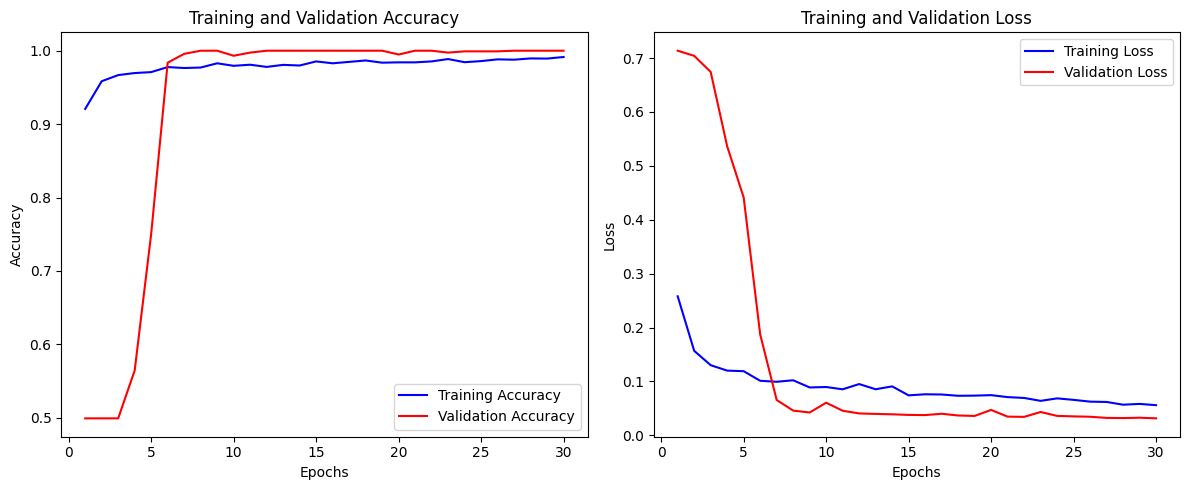

In [ ]:
# Plot Training and Validation Metrics
def plot_metrics(history):
    # Extract metrics
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Print final metrics
    print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
    print(f"Final Training Loss: {training_loss[-1]:.4f}")
    print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")
    print(f"Final Validation Loss: {validation_loss[-1]:.4f}")

    # Plot metrics
    epochs = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, 'b-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(history)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# predictions on the testing set
predictions = model_optimized.predict(test_generator)

# Converting predictions to binary no (0 or 1) based on a 0.5
binary_predictions = (predictions > 0.5).astype(int).flatten()

# true labels from the generator
true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

classification_rep = classification_report(true_labels, binary_predictions, target_names=test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_rep)

print(f'\nTesting Accuracy: {test_accuracy:.4f}')
print(f'Testing Loss: {test_loss:.4f}')


5/5 [==============================] - 4s 753ms/step
Confusion Matrix:
[[127  18]
 [  1 148]]

Classification Report:
                 precision    recall  f1-score   support

  1_Clean_Water       0.99      0.88      0.93       145
2_Microplastics       0.89      0.99      0.94       149

       accuracy                           0.94       294
      macro avg       0.94      0.93      0.94       294
   weighted avg       0.94      0.94      0.94       294


Testing Accuracy: 0.9354
Testing Loss: 0.1927


In [ ]:

print("True Labels:")
print(true_labels)
print(f'---------------------------------------------------------')
print("Testing Predicted Labels:")
print(binary_predictions.flatten())

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
---------------------------------------------------------
Testing Predicted Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 1 1 1

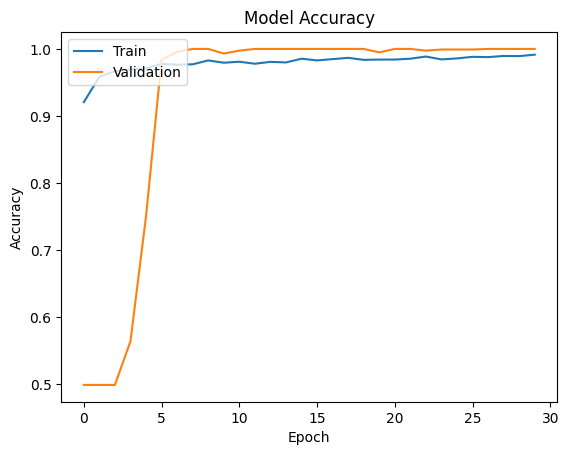

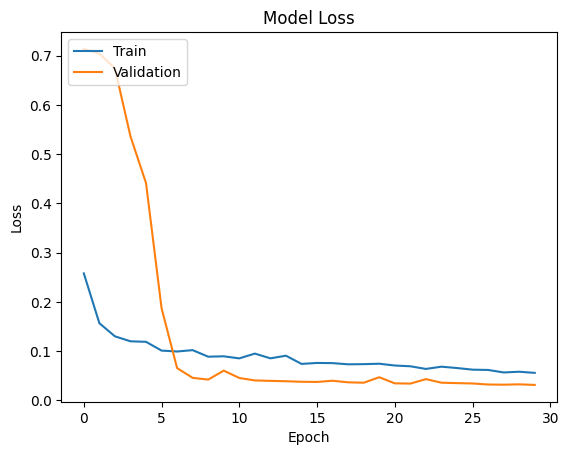

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:

########################################################################

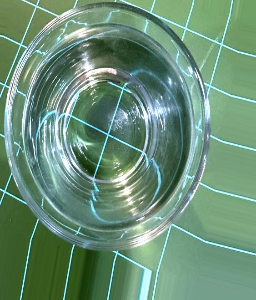

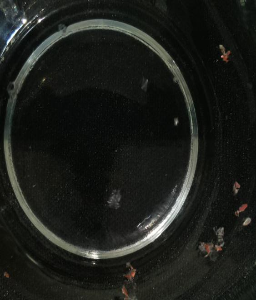

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Replace with the path to your image
test_clean_image_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training/1_Clean_Water_aug/augg_BY_jay_0_1100.jpg'
test_microPla_image_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing/2_Microplastics/c--108-_jpg.rf.f7659d7bba7f0f55ea596447f18653e0.jpg'
# Load the image using OpenCV
clean_image = cv2.imread(test_clean_image_path)
clean_image = cv2.resize(clean_image,(256,300))
microPla_image = cv2.imread(test_microPla_image_path)
microPla_image = cv2.resize(microPla_image,(256,300))

cv2_imshow(clean_image)
cv2_imshow(microPla_image)

In [ ]:
from skimage.transform import resize
import numpy as np


microPla_image = resize(microPla_image, (128, 128))
microPla_image = microPla_image.astype('float32') / 255.0
microPla_image = np.expand_dims(microPla_image, axis=0)

prediction = model_optimized.predict(microPla_image)

# If prediction is greater than 0.5, classify as Plastics (1), else Clean (0)
if prediction >= 0.5:
    print("Prediction: Plastics")
else:
    print("Prediction: Clean")


NameError: name 'model_optimized' is not defined

In [ ]:
# Testing alternative activation functions to find best candidates

# Creating activation list
activation_functions = ['leaky_relu', 'elu', 'tanh', 'selu', 'sigmoid', 'relu']

# Creating a dictionary to hold the activation function accuracy results
results = {}

# For-Looping the activation functions through the model
for activation in activation_functions:
    print(f"Training model with activation: {activation}")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

    # Pulling the results
    results[activation] = history.history['val_accuracy']

# Plotting the results
plt.figure(figsize=(10, 6))

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
for activation, accuracy in results.items():
    plt.plot(accuracy, label=activation)

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()